# Прогноз оттока клиентов телеком-оператора

Цель проекта - Разработка и обучение модели машинного обучения, способной прогнозировать уход клиентов телеком-оператора «ТелеДом». Это позволит бизнесу заранее выявлять абонентов с высоким риском оттока и предлагать им специальные условия обслуживания или индивидуальные предложения.

___

Задачи проекта:

- Изучить и обработать исходные данные, предоставленные в четырёх таблицах базы данных:
  - `contract` — сведения о договоре (ID клиента, даты начала и окончания, способ оплаты, расходы и пр.);
  - `personal` — демографические и семейные признаки клиента (пол, пенсионный статус, наличие партнёра);
  - `internet` — информация об интернет-услугах, подключённых пользователем (тип подключения, Online Security, Backup, Tech Support, стриминговые сервисы и др.);
  - `phone` — сведения об услугах телефонии (использование нескольких линий и пр.).

- Провести исследовательский анализ данных:
  - проверить наличие пропусков и аномалий;
  - изучить распределения признаков и особенности предоставления телеком-услуг.

- Объединить таблицы по ID клиента в единый датафрейм, где каждое наблюдение соответствует одному клиенту.

- Сформировать целевую переменную (`churn`) на основе даты окончания договора, а также сгенерировать дополнительные признаки.

- Подготовить данные для моделирования:
  - закодировать категориальные признаки;
  - масштабировать числовые;
  - разбить данные на обучающую и тестовую выборки (test_size = 0.25).

- Обучить несколько моделей машинного обучения:
  - логистическую регрессию;
  - дерево решений;
  - случайный лес;
  - градиентный бустинг и его вариации;
  - простую нейронную сеть.

- Провести подбор гиперпараметров и оценить модели по метрике ROC-AUC с использованием кросс-валидации.

- Выбрать лучшую модель и протестировать её на тестовой выборке, дополнительно оценив точность (accuracy), полноту (recall), точность (precision) и F1-меру. Одно из требований **ROC-AUC >= 0.85.**

- Проанализировать значимость признаков, влияющих на отток.

- Сформулировать финальные выводы и предоставить рекомендации на основе результатов модели.

___

Описание услуг и признаков:

Оператор предоставляет два основных типа услуг:
- Стационарная телефонная связь, включая возможность подключения к нескольким линиям;
- Подключение к интернету по технологии DSL или оптоволоконной линии.

Дополнительно доступны сервисы:
- Безопасность: блокировка опасных сайтов (Online Security), резервное копирование данных (Online Backup), антивирус (Device Protection);
- Поддержка и развлечения: выделенная линия техподдержки (Tech Support), стриминговое телевидение (Streaming TV), каталог фильмов (Streaming Movies).

Клиенты могут оплачивать услуги ежемесячно либо раз в 1–2 года, используя различные способы оплаты: банковский счёт, электронные чеки, наличные и пр.

**Информация о договорах актуальна на 1 февраля 2020 года.**


## Загрузка данных

In [1]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db
!pip install scikit-learn==1.4.0 

--2025-04-25 08:31:38--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.14’

ds-plus-final.db.14 100%[===================>]   3.42M  --.-KB/s    in 0.06s   

2025-04-25 08:31:38 (56.1 MB/s) - ‘ds-plus-final.db.14’ saved [3588096/3588096]

     |████████████████████████████████| 12.1 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 94.6 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled s

In [2]:
!pip install phik

import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

from sklearn.metrics import (
    roc_auc_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, f1_score)

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import phik
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

RANDOM_STATE = 210425
TEST_SIZE = 0.25

warnings.filterwarnings('ignore')
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

     |████████████████████████████████| 686 kB 2.1 MB/s eta 0:00:01


In [3]:
query_tables = """
SELECT name FROM sqlite_master
WHERE type='table'
"""

pd.read_sql(query_tables, con=engine)

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


Все 4 таблицы, которые необходимы для нашего исследования присутсвуют в базе данных.

In [4]:
df_contracts = pd.read_sql('SELECT * FROM contract', con=engine)
df_person = pd.read_sql('SELECT * FROM personal', con=engine)
df_inet = pd.read_sql('SELECT * FROM internet', con=engine)
df_phone = pd.read_sql('SELECT * FROM phone', con=engine)

In [5]:
tables = {
    'contract': df_contracts,
    'personal': df_person,
    'internet': df_inet,
    'phone': df_phone}

for name, df in tables.items():
    print(f"Таблица: {name}")
    print()
    print(f"Размер: {df.shape}")
    display(df.sample(3, random_state=RANDOM_STATE))

Таблица: contract

Размер: (7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2967,7663-CUXZB,2015-03-01,No,Two year,No,Electronic check,113.75,6845.48
1571,2812-SFXMJ,2020-01-01,No,Month-to-month,No,Mailed check,20.05,20.05
3237,6734-JDTTV,2014-09-01,No,Two year,Yes,Credit card (automatic),19.85,1290.25


Таблица: personal

Размер: (7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
2967,7663-CUXZB,Male,0,Yes,No
1571,2812-SFXMJ,Male,0,No,Yes
3237,6734-JDTTV,Male,0,Yes,Yes


Таблица: internet

Размер: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4852,8821-KVZKQ,DSL,No,Yes,Yes,Yes,Yes,Yes
3487,6087-MVHJH,Fiber optic,No,No,Yes,No,No,Yes
276,1343-EHPYB,Fiber optic,No,Yes,Yes,No,Yes,Yes


Таблица: phone

Размер: (6361, 2)


,CustomerId,MultipleLines
65,0731-EBJQB,No
2176,9314-QDMDW,No
5710,0186-CAERR,Yes


Выводы по этапу загрузки и первичного анализа:

На данном этапе мы выполнили подключение к базе данных и задали фиксированное значение `RANDOM_STATE = 210425`, которое будет использоваться на всех этапах, где применяются случайности (например, разбиение выборки, случайные подвыборки, инициализация моделей).

Мы проверили структуру базы и убедились, что все четыре необходимые таблицы (`contract`, `personal`, `internet`, `phone`) присутствуют и готовы к анализу. Далее мы загрузили содержимое таблиц в датафреймы и изучили по три случайные записи из каждой.

Первичные наблюдения:

- Таблица `contract` содержит информацию о договоре: даты начала и окончания, тип контракта, способ оплаты, ежемесячные и общие траты клиента. Признаки имеют корректный вид на первый взгляд.

- Таблица `personal` включает демографические и семейные признаки: пол, пенсионный статус (`SeniorCitizen` представлен в числовом виде 0/1), наличие партнёра.

- Таблица `internet` содержит информацию об интернет-услугах: тип подключения (`DSL` или `Fiber optic`) и наличие дополнительных сервисов (бэкап, антивирус, техподдержка и пр.).

- Таблица `phone` хранит информацию об услугах телефонии. Признак `MultipleLines` указывает, подключена ли у клиента возможность использования нескольких линий.

Таблицы имеют разное количество строк, что может указывать на отсутствие отдельных типов услуг у части клиентов. Это следует учитывать при объединении таблиц по `customerID`.

___


На следующем этапе мы приступим к более подробному исследовательскому анализу данных: проверим типы признаков, наличие пропусков и аномалий, оценим распределения и подготовим данные к объединению.


## Исследовательский анализ и предобработка данных

In [6]:
def analyze_dataframe(df, name):
    total_rows = len(df)
    analysis = pd.DataFrame({
        'Column': df.columns,
        'Missing Values': df.isnull().sum(),
        'Missing %': (df.isnull().sum() / total_rows * 100).round(2),
        'Data Type': df.dtypes,
        'Unique Values': df.nunique()})

    analysis.set_index('Column', inplace=True)
    print(f"Таблица: {name}")
    display(analysis)
    print(f"Количество дубликатов: {df.duplicated().sum()}")
    return analysis

_ = analyze_dataframe(df_contracts, 'contract')
_ = analyze_dataframe(df_person, 'personal')
_ = analyze_dataframe(df_inet, 'internet')
_ = analyze_dataframe(df_phone, 'phone')

Таблица: contract


,Missing Values,Missing %,Data Type,Unique Values
Column,,,,
customerID,0,0.0,object,7043
BeginDate,0,0.0,object,77
EndDate,0,0.0,object,67
Type,0,0.0,object,3
PaperlessBilling,0,0.0,object,2
PaymentMethod,0,0.0,object,4
MonthlyCharges,0,0.0,object,1585
TotalCharges,0,0.0,object,6658


Количество дубликатов: 0
Таблица: personal


,Missing Values,Missing %,Data Type,Unique Values
Column,,,,
customerID,0,0.0,object,7043
gender,0,0.0,object,2
SeniorCitizen,0,0.0,object,2
Partner,0,0.0,object,2
Dependents,0,0.0,object,2


Количество дубликатов: 0
Таблица: internet


,Missing Values,Missing %,Data Type,Unique Values
Column,,,,
customerID,0,0.0,object,5517
InternetService,0,0.0,object,2
OnlineSecurity,0,0.0,object,2
OnlineBackup,0,0.0,object,2
DeviceProtection,0,0.0,object,2
TechSupport,0,0.0,object,2
StreamingTV,0,0.0,object,2
StreamingMovies,0,0.0,object,2


Количество дубликатов: 0
Таблица: phone


,Missing Values,Missing %,Data Type,Unique Values
Column,,,,
CustomerId,0,0.0,object,6361
MultipleLines,0,0.0,object,2


Количество дубликатов: 0


Ни в одной из таблиц пропущенных значений или повторяющихся строк обнаружено не
было. Это говорит о хорошем качестве исходных данных. В дальнейшем необходимо будет привести все данные к корректым типам.

In [7]:
def to_snake_case_columns(df):
    def convert(col):
        col = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
        col = re.sub('([a-z0-9])([A-Z])', r'\1_\2', col)
        return col.lower().replace(' ', '_').replace('-', '_').strip()
    df.columns = [convert(col) for col in df.columns]
    return df

df_contracts = to_snake_case_columns(df_contracts)
df_person = to_snake_case_columns(df_person)
df_inet = to_snake_case_columns(df_inet)
df_phone = to_snake_case_columns(df_phone)

Для повышения читаемости и унификации все названия столбцов были приведены к стилю `snake_case`. Это упростит дальнейшую обработку и объединение таблиц.


In [8]:
df_contracts['begin_date'] = pd.to_datetime(df_contracts['begin_date'], errors='coerce')
df_contracts['end_date'] = pd.to_datetime(df_contracts['end_date'], errors='coerce')

df_contracts['monthly_charges'] = pd.to_numeric(df_contracts['monthly_charges'], errors='coerce')
df_contracts['total_charges'] = pd.to_numeric(df_contracts['total_charges'], errors='coerce')

df_contracts['total_charges'] = df_contracts['total_charges'].fillna(0)

Преобразовали данные в корректные типы

- Даты (`begin_date` и `end_date`) преобразованы в формат `datetime`.
- Числовые значения `monthly_charges` и `total_charges` приведены к типу `float`.
- Пропущенные значения в `total_charges`, возникшие из-за некорректного формата исходных данных, были заполнены нулями, так как соответствуют клиентам без трат.

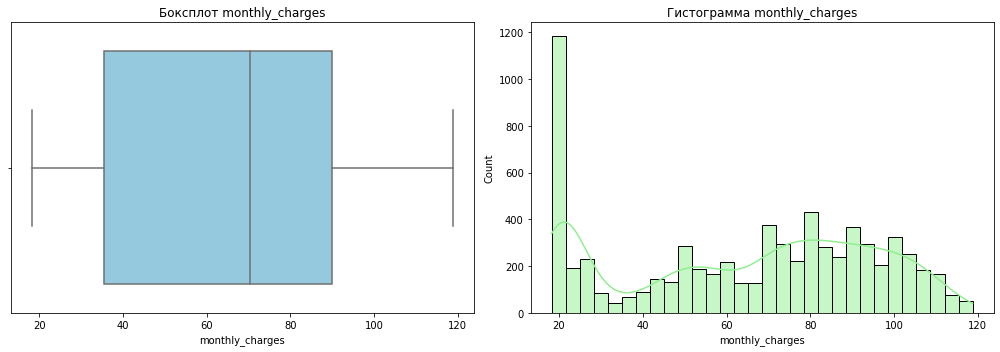

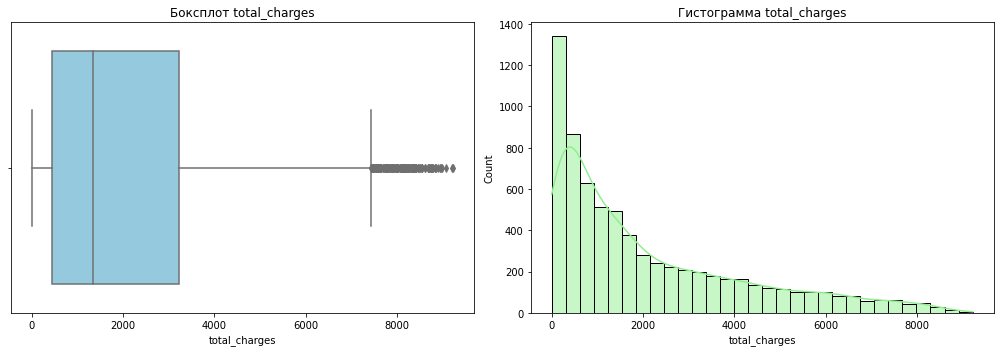

In [9]:
def analyze_numeric(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(f'Боксплот {col}')

        plt.subplot(1, 2, 2)
        sns.histplot(df[col], kde=True, bins=30, color='lightgreen')
        plt.title(f'Гистограмма {col}')

        plt.tight_layout()
        plt.show()

analyze_numeric(df_contracts)

Визуализировали распределения признаков `monthly_charges` и `total_charges` с помощью боксплота и гистограмм.

- В распределение `monthly_charges` аномалий не выявлено.
- Признак `total_charges` имеет выраженное правостороннее распределение, характерное для накапливаемых величин. В данных присутствует длинный хвост с высокими значениями.
- Выбросы на графиках являются допустимыми значениями, отражающими особенности телеком-услуг (например, клиентов с длительным сроком использования). Решено не удалять.

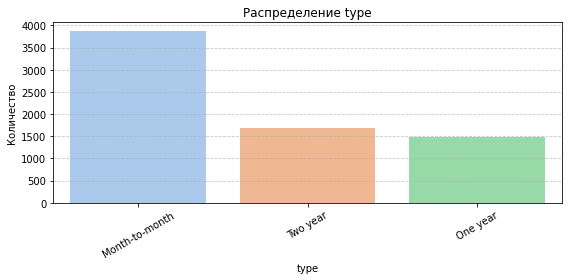

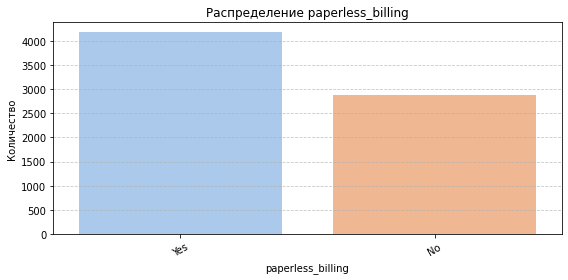

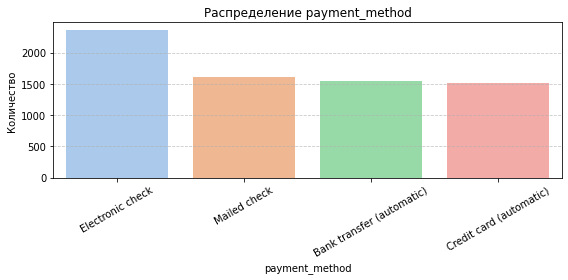

In [10]:
def analyze_categorical(df):
    cat_cols = [col for col in df.select_dtypes(include='object').columns
                if col != 'customer_id']

    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='pastel')
        plt.title(f'Распределение {col}')
        plt.xticks(rotation=30)
        plt.ylabel('Количество')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

analyze_categorical(df_contracts)

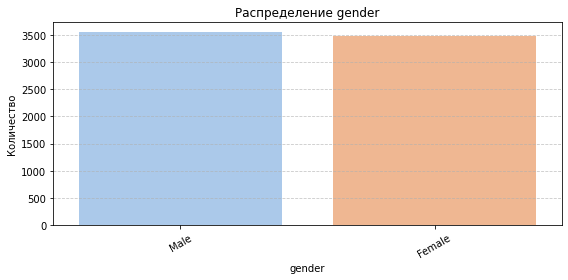

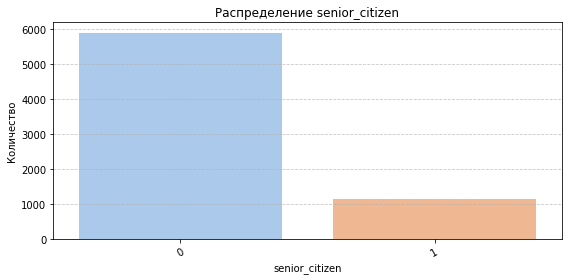

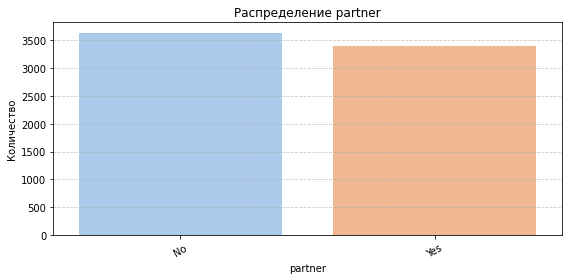

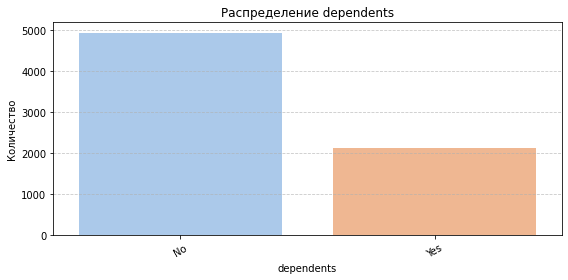

In [11]:
analyze_categorical(df_person)

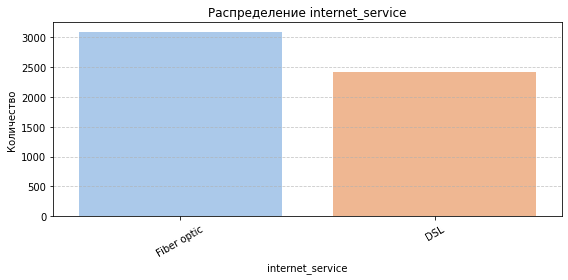

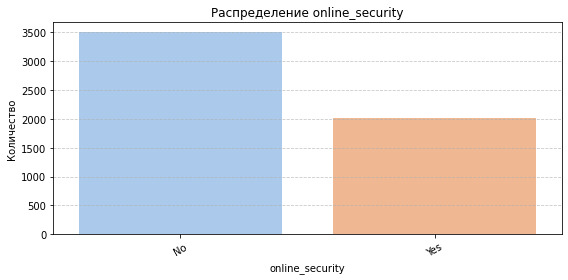

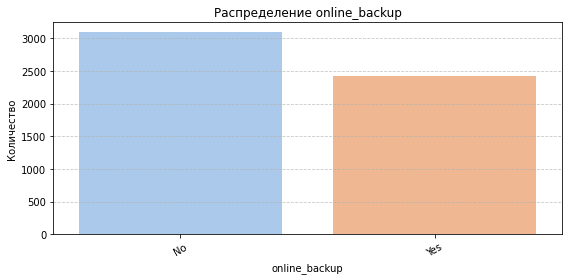

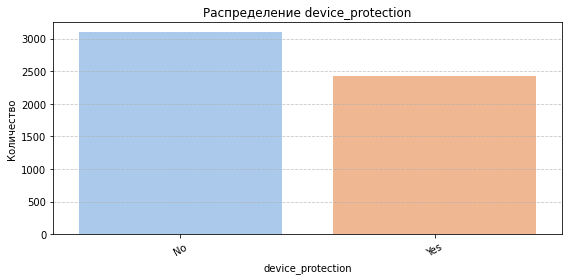

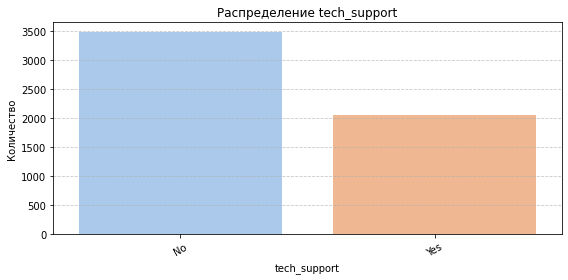

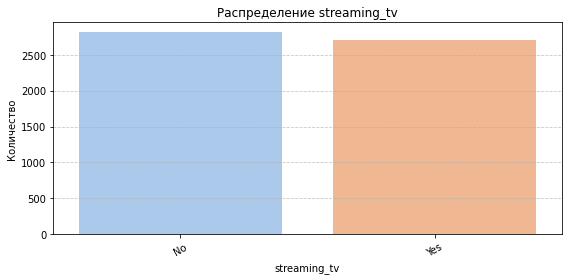

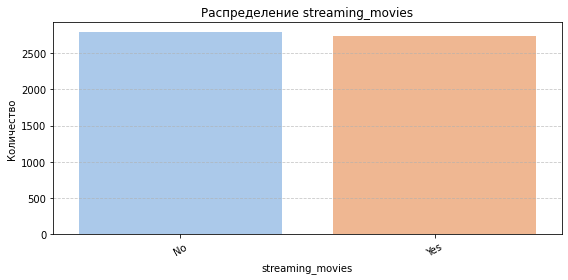

In [12]:
analyze_categorical(df_inet)

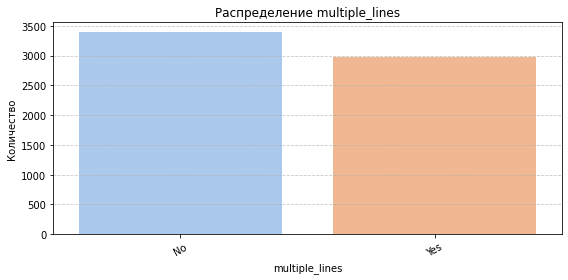

In [13]:
analyze_categorical(df_phone)

Мы провели визуальный анализ распределения категориальных признаков:

- Тип контракта (`type`) - наибольшее количество клиентов используют помесячную оплату (`Month-to-month`), что может потенциально коррелировать с оттоком.
- Электронная оплата (`paperless_billing`) - более половины пользователей предпочитают получать электронные счета.
- Способ оплаты (`payment_method`) - наиболее популярным вариантом является `Electronic check`.

- Пол (`gender`) - распределение между мужчинами и женщинами почти равное.
- Пенсионеры (`senior_citizen`) - большинство клиентов не являются пенсионерами.
- Наличие партнёра (`partner`) и детей (`dependents`): заметная часть клиентов живёт без партнёра и детей.

- Интернет-услуги (`internet_service`) - наибольшая доля клиентов использует `Fiber optic` подключение.
- Дополнительные онлайн-услуги (безопасность, резервное копирование, защита устройства, техподдержка) - доля пользователей, подключивших каждую из этих опций, заметно меньше, чем тех, кто отказался.
- Стриминговые сервисы (`streaming_tv`, `streaming_movies`) - количество пользователей с активными услугами примерно равно числу отказавшихся.
- Множественные линии телефонии (`multiple_lines`) - наблюдается равномерное распределение между теми, кто использует одну или несколько линий.

In [14]:
df = df_contracts.merge(df_person, on='customer_id', how='left') \
                 .merge(df_inet, on='customer_id', how='left') \
                 .merge(df_phone, on='customer_id', how='left')

Мы объединили все таблицы по признаку `customer_id`, на основе таблицы `contract`, содержащей полный список клиентов.

In [15]:
df['churn'] = df['end_date'].apply(lambda x: 1 if pd.notnull(x) else 0)

Таргет-признак `churn` — факт ухода клиента.

- Если дата окончания договора (`end_date`) заполнена, считаем, что клиент прекратил обслуживание (`churn = 1`);
- Если дата отсутствует (`NaT`), клиент продолжает пользоваться услугами оператора (`churn = 0`).

In [16]:
df['contract_duration'] = (df['end_date'].fillna(pd.to_datetime("2020-02-01")) - df['begin_date']).dt.days

Для каждого клиента рассчитана длительность пользования услугами на момент окончания контракта. Для клиентов, которые не ушли, в качестве даты окончания использовано контрольное значение — 1 февраля 2020 года.

Признак `contract_duration` выражен в днях и рассчитывается как разность между датой окончания и датой начала контракта. Он отражает степень лояльности клиента.

In [17]:
_ = analyze_dataframe(df, 'Объединённая таблица')

Таблица: Объединённая таблица


,Missing Values,Missing %,Data Type,Unique Values
Column,,,,
customer_id,0,0.00,object,7043
begin_date,0,0.00,datetime64[ns],77
end_date,5942,84.37,datetime64[ns],66
type,0,0.00,object,3
paperless_billing,0,0.00,object,2
payment_method,0,0.00,object,4
monthly_charges,0,0.00,float64,1585
total_charges,0,0.00,float64,6658
gender,0,0.00,object,2


Количество дубликатов: 0


In [18]:
check = ['internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies', 'multiple_lines']

for col in check:
    print(f"Уникальные признаки в  {col}:")
    print(df[col].unique())

Уникальные признаки в  internet_service:
['DSL' 'Fiber optic' nan]
Уникальные признаки в  online_security:
['No' 'Yes' nan]
Уникальные признаки в  online_backup:
['Yes' 'No' nan]
Уникальные признаки в  device_protection:
['No' 'Yes' nan]
Уникальные признаки в  tech_support:
['No' 'Yes' nan]
Уникальные признаки в  streaming_tv:
['No' 'Yes' nan]
Уникальные признаки в  streaming_movies:
['No' 'Yes' nan]
Уникальные признаки в  multiple_lines:
[nan 'No' 'Yes']


In [19]:
internet_cols = [
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies']

df['internet_service'] = df['internet_service'].fillna('No')

df.loc[df['internet_service'] == 'No', internet_cols] = 'no_internet'

df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

После объединения таблиц в единый датафрейм df мы обнаружили пропущенные значения в категориальных признаках: internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies и multiple_lines.

Пропуски в этих колонках возникают из-за отсутствия основной услуги. Например, если у клиента не подключён интернет, то и дополнительных интернет-услуг быть не может. Аналогично, если не подключена телефония, то multiple_lines также будет пустым.

Чтобы корректно отразить такую ситуацию:

- Пропуски в `internet_service` были заменены на 'No', а в связанных с интернетом колонках — на 'no_internet'.
- Пропуски в `multiple_lines были` заменены на 'no_phone'.

Таким образом, мы избежали искажения информации, не приписывая клиентам несуществующие услуги

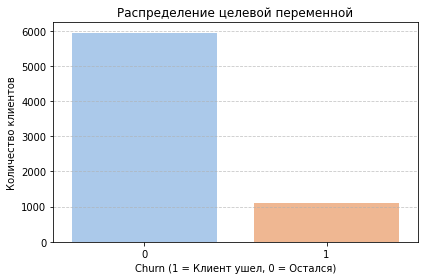

0    0.84
1    0.16
Name: churn, dtype: float64

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df, palette='pastel')
plt.title('Распределение целевой переменной')
plt.xlabel('Churn (1 = Клиент ушел, 0 = Остался)')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df['churn'].value_counts(normalize=True).round(2)

Распределение классов в таргете оказалось несбалансированным:
- 84% клиентов продолжают пользоваться услугами оператора,
- 16% клиентов ушли.

Дисбаланс классов следует учитывать при обучении модели:
- При выборе метрик качества;
- При разделении выборки (применять стратифицированное разбиение).

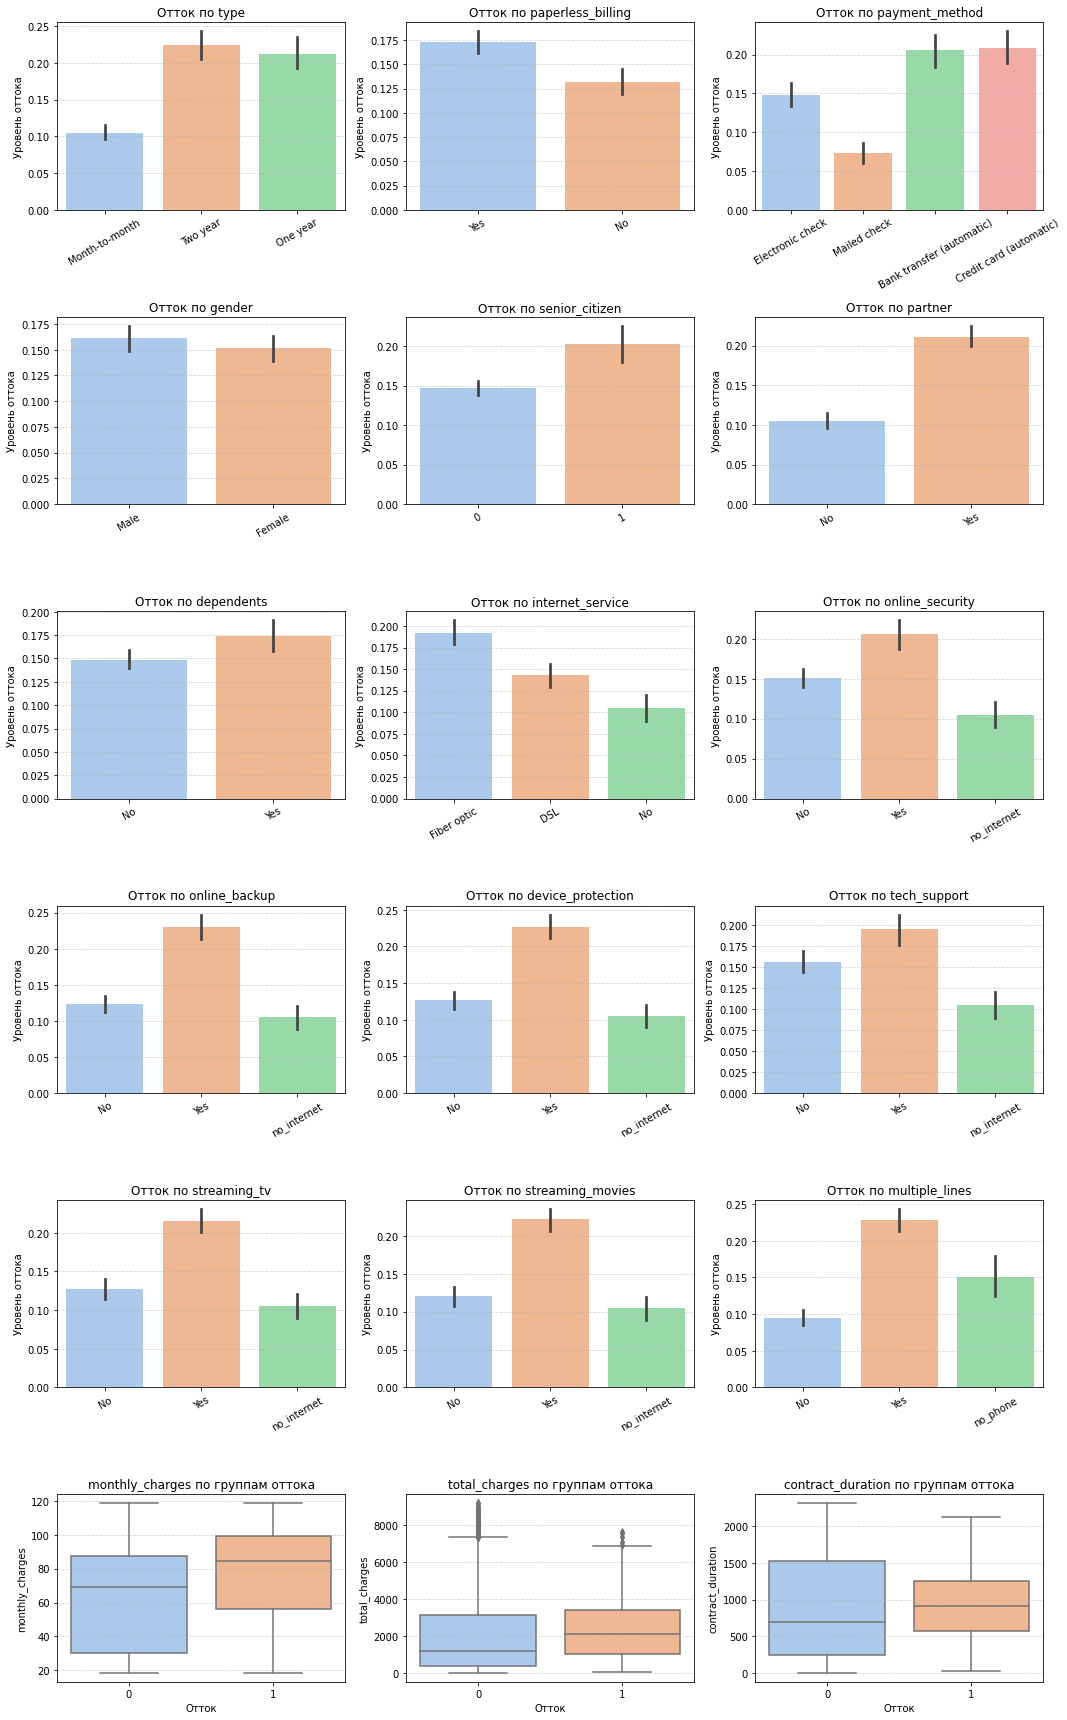

In [21]:
def plot_churn_relation(df, target='churn', cols_per_row=3):
    cat_columns = [
        col for col in df.select_dtypes(include='object').columns
        if col not in ['customer_id', 'begin_date', 'end_date']]

    num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    num_columns = [col for col in num_columns if col not in [target]]

    total_plots = len(cat_columns) + len(num_columns)
    rows = (total_plots + cols_per_row - 1) // cols_per_row
    plt.figure(figsize=(cols_per_row * 5, rows * 4))
    plot_index = 1

    for col in cat_columns:
        plt.subplot(rows, cols_per_row, plot_index)
        order = df[col].value_counts().index
        sns.barplot(data=df, x=col, y=target, order=order, palette='pastel')
        plt.title(f'Отток по {col}')
        plt.ylabel('Уровень оттока')
        plt.xlabel('')
        plt.xticks(rotation=30)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plot_index += 1

    for col in num_columns:
        plt.subplot(rows, cols_per_row, plot_index)
        sns.boxplot(data=df, x=target, y=col, palette='pastel')
        plt.title(f'{col} по группам оттока')
        plt.xlabel('Отток')
        plt.ylabel(col)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plot_index += 1

    plt.tight_layout()
    plt.show()

plot_churn_relation(df)

Ключевые признаки:

- Метод оплаты (`payment_method`) - наименьший уровень оттока наблюдается у клиентов, оплачивающих услуги через бумажные чеки (`Mailed Check`). Наоборот, автоматические способы оплаты — `Bank transfer (automatic)` и `Credit card (automatic)` — связаны с повышенным оттоком.

- Возраст (`senior_citizen`) - клиенты пенсионного возраста демонстрируют более высокий уровень оттока по сравнению с остальными.

- Техническая поддержка (`tech_support`) - отток выше у тех клиентов, у кого подключена услуга технической поддержки. Это может указывать на то, что техподдержку чаще подключают клиенты с проблемами или негативным опытом.

- Ежемесячные платежи (`monthly_charges`) - клиенты с более высокими ежемесячными расходами уходят чаще. Вероятно, цена услуг оказывает прямое влияние на решение прекратить сотрудничество.


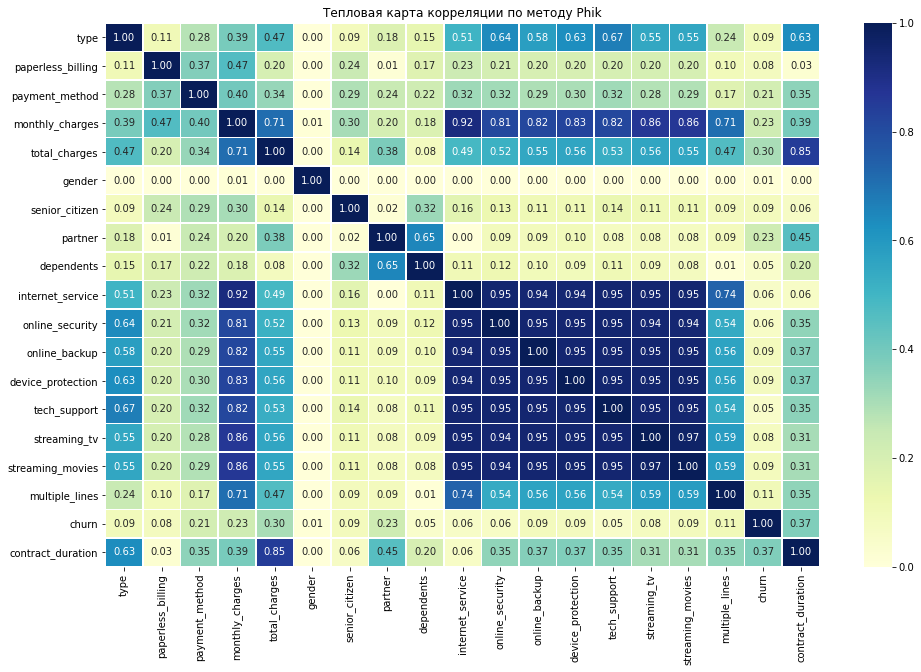

In [22]:
df_filtered = df.drop(columns=['customer_id', 'begin_date', 'end_date'])
numerical_cols = ['monthly_charges', 'total_charges', 'contract_duration']

phik_matrix = df_filtered.phik_matrix(interval_cols=numerical_cols)

plt.figure(figsize=(16, 10))
sns.heatmap(phik_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта корреляции по методу Phik')
plt.show()

In [23]:
df = df.drop(columns=[
    'customer_id', 'begin_date', 'end_date',
    'online_security', 'online_backup', 'device_protection',
    'tech_support', 'streaming_tv', 'streaming_movies'])

Мы провели анализ взаимосвязей между признаками с помощью матрицы Phik.

Была выявлена сильная корреляция между множеством дополнительных интернет-услуг (таких как online_security, tech_support и др.), а также между ними и признаками `internet_service` и `monthly_charges`. Чтобы избежать мультиколлинеарности, мы исключили все дополнительные интернет-признаки, оставив только базовый признак `internet_service`, отражающий сам факт подключения услуги. Это позволяет сохранить интерпретируемость и избежать искажения важности признаков при обучении модели.

Также сохраняется высокая корреляция между `internet_service` и `monthly_charges` (Phik = 0.92), однако в данном случае было принято решение оставить оба признака — они отражают разные аспекты, важные для бизнес-анализа.

Признаки begin_date и end_date были удалены, чтобы избежать утечки информации. Они уже использовались при создании производного признака contract_duration, и их сохранение могло бы привести к переобучению. Также они не несут дополнительной ценности в задаче без временной динамики.

Кроме того, был удалён customer_id как технический идентификатор, не несущий полезной информации для предсказания.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   object 
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  multiple_lines     7043 non-null   object 
 11  churn              7043 non-null   int64  
 12  contract_duration  7043 non-null   int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 1.0+ MB


In [25]:
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [26]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_columns)])

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns)],
    remainder='passthrough')

In [27]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_tree = tree_preprocessor.fit_transform(X_train)
X_test_tree = tree_preprocessor.transform(X_test)

print(f"Размеры выборок после преобразования для итогового обучения - X_train: {X_train_processed.shape}, X_test: {X_test_processed.shape}")

Размеры выборок после преобразования для итогового обучения - X_train: (5282, 17), X_test: (1761, 17)


Вывод по анализу и предобработке данных:

Проверили наличие данных во всех четырёх целевых таблицах (contract, personal, internet, phone) — дубликатов не обнаружено.

Выполнили базовый анализ всех признаков: изучили распределения числовых переменных (monthly_charges, total_charges) и категориальных (type, payment_method, gender и прочих). Выбросы в числовых данных были допустимыми — оставлены.

Привели названия всех колонок к snake_case для улучшения читаемости.

Объединили таблицы по `customer_id`, сформировав единый датафрейм с полными данными на одного клиента.

Выделили целевую переменную `churn` на основе наличия даты окончания договора (end_date). Создали дополнительный признак — продолжительность контракта (contract_duration), рассчитанную как разность между датами.

Заполнили пропуски в категориальных бинарных признаках (online_security, online_backup) значением 'No', что логично с точки зрения предметной области: отсутствие услуги равно как отказ от неё.

Исследовали распределение целевой переменной: обнаружили дисбаланс классов (≈ 84% клиентов остались, ≈ 16% ушли), что важно учитывать при обучении моделей и выборе метрик.

Визуализировали уровень оттока по каждому признаку. Выделены потенциально значимые факторы (например, высокая зависимость от метода оплаты, возраста клиента и уровня ежемесячных платежей).

Провели корреляционный анализ методом Phik. Выявили высокую корреляцию между `monthly_charges` и `internet_service` (0.92) — удалили `internet_service` как менее информативный. Также исключили неинформативные признаки (customer_id, begin_date, end_date) во избежание утечек.

Разделили данные на обучающую и тестовую выборки с параметрами test_size=0.25, stratify=y, random_state=210425.

Выполнили финальную предобработку с помощью ColumnTransformer: числовые признаки масштабированы (StandardScaler), категориальные — закодированы (OneHotEncoder) - данные выборки будем использовать для обучения линейный моделей и нейронных сетей.

Выполнили предобработку через кодирование (OrdinalEncoder) и оставили выборки без мастабирования для моделей основанных на обучению по принципу построения деревьев.

## Обучение моделей

На данном этапе мы обучим и сравним несколько моделей , чтобы определить наиболее подходящую для прогнозирования оттока клиентов.

Будут протестированы различные подходы:

- базовая модель `DummyClassifier`, которая будет отправной точкой для сравнения;
- логистическая регрессия;
- дерево решений и случайный лес;
- градиентные бустинги (`XGBoost`, `LightGBM`);
- простая нейронная сеть.

Оценка моделей будет производиться по метрике **ROC-AUC** с использованием **кросс-валидации**. Произведем перебор гиперпараметров для классических моделей.

Все результаты будут сведены в итоговую таблицу, на основе которой выберем наилучший результат.

In [28]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_processed, y_train)

y_prob = dummy_clf.predict_proba(X_test_processed)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC DummyClassifier: {roc_auc}")

ROC-AUC DummyClassifier: 0.5321681145234308


In [29]:
logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']}

grid_logreg = GridSearchCV(logreg,
                           param_grid=param_grid_logreg,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1,
                           verbose=0)

start_time_logreg = time.time()
grid_logreg.fit(X_train_processed, y_train)
end_time_logreg = time.time()

print("Лучшие параметры LogisticRegression:")
print(grid_logreg.best_params_)

score_logreg = grid_logreg.best_score_
print(f"Лучшее значение ROC-AUC на кросс-валидации: {score_logreg:.4f}")
print(f"Время обучения: {round(end_time_logreg - start_time_logreg, 2)}")


Лучшие параметры LogisticRegression:
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшее значение ROC-AUC на кросс-валидации: 0.7683
Время обучения: 4.05


In [30]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_tree = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

grid_tree = GridSearchCV(tree,
                         param_grid=param_grid_tree,
                         scoring='roc_auc',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)

start_time_tree = time.time()
grid_tree.fit(X_train_tree, y_train)
end_time_tree = time.time()

print("Лучшие параметры DecisionTree:")
print(grid_tree.best_params_)

score_tree = grid_tree.best_score_
print(f"Лучшее значение ROC-AUC на кросс-валидации: {score_tree:.4f}")
print(f"Время обучения: {round(end_time_tree - start_time_tree, 2)}")

Лучшие параметры DecisionTree:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшее значение ROC-AUC на кросс-валидации: 0.7836
Время обучения: 2.99


In [31]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}

grid_rf = GridSearchCV(rf_model,
                       param_grid=param_grid_rf,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1,
                       verbose=0)

start_time_rf = time.time()
grid_rf.fit(X_train_tree, y_train)
end_time_rf = time.time()

print("Лучшие параметры RandomForest:")
print(grid_rf.best_params_)

score_rf = grid_rf.best_score_
print(f"Лучшее значение ROC-AUC на кросс-валидации: {score_rf:.4f}")
print(f"Время обучения: {round(end_time_rf - start_time_rf, 2)}")

Лучшие параметры RandomForest:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Лучшее значение ROC-AUC на кросс-валидации: 0.8305
Время обучения: 56.53


In [32]:
xgb_model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3]}

grid_xgb = GridSearchCV(xgb_model,
                        param_grid=param_grid_xgb,
                        scoring='roc_auc',
                        cv=5,
                        n_jobs=-1,
                        verbose=0)

start_time_xgb = time.time()
grid_xgb.fit(X_train_tree, y_train)
end_time_xgb = time.time()

print("Лучшие параметры XGBClassifier:")
print(grid_xgb.best_params_)

score_xgb = grid_xgb.best_score_
print(f"Лучшее значение ROC-AUC на кросс-валидации: {score_xgb:.4f}")
print(f"Время обучения: {round(end_time_xgb - start_time_xgb, 2)}")


Лучшие параметры XGBClassifier:
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 150}
Лучшее значение ROC-AUC на кросс-валидации: 0.8874
Время обучения: 507.99


In [33]:
lgbm_model = LGBMClassifier(random_state=RANDOM_STATE)

X_lgb_train = X_train.copy()
X_lgb_test = X_test.copy()

for col in categorical_columns:
    X_lgb_train[col] = X_lgb_train[col].astype('category')
    X_lgb_test[col] = X_lgb_test[col].astype('category')

param_grid_lgbm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3]}

grid_lgbm = GridSearchCV(lgbm_model,
                         param_grid=param_grid_lgbm,
                         scoring='roc_auc',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)

start_time_lgbm = time.time()
grid_lgbm.fit(X_lgb_train, y_train)
end_time_lgbm = time.time()

print("Лучшие параметры LGBMClassifier:")
print(grid_lgbm.best_params_)

score_lgbm = grid_lgbm.best_score_
print(f"Лучшее значение ROC-AUC на кросс-валидации: {score_lgbm:.4f}")
print(f"Время обучения: {round(end_time_lgbm - start_time_lgbm, 2)}")

Лучшие параметры LGBMClassifier:
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 150}
Лучшее значение ROC-AUC на кросс-валидации: 0.8902
Время обучения: 82.99


In [34]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

roc_auc_scores = []
total_start_time = time.time()

fold = 1

for train_idx, val_idx in kf.split(X_train_processed):
    fold_start_time = time.time()

    X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_fold_train, y_fold_val = y_train.values[train_idx], y_train.values[val_idx]

    model = Sequential([
        Dense(100, activation='relu', input_shape=(X_fold_train.shape[1],)),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0)

    y_fold_prob = model.predict(X_fold_val).ravel()
    roc_auc = roc_auc_score(y_fold_val, y_fold_prob)
    roc_auc_scores.append(roc_auc)

    fold_end_time = time.time()
    print(f"Fold {fold} ROC-AUC: {roc_auc:.4f} | Время: {round(fold_end_time - fold_start_time, 2)} сек")

    fold += 1

total_end_time = time.time()
mean_auc = np.mean(roc_auc_scores)

print(f"Средний ROC-AUC по {n_splits}-фолдовой кросс-валидации: {mean_auc:.4f}")
print(f"Общее время обучения нейросети: {round(total_end_time - total_start_time, 2)}")


2025-04-25 08:43:01.076129: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 1 ROC-AUC: 0.8354 | Время: 8.18 сек
Fold 2 ROC-AUC: 0.8347 | Время: 9.13 сек
Fold 3 ROC-AUC: 0.7689 | Время: 5.25 сек
Fold 4 ROC-AUC: 0.8281 | Время: 10.55 сек
Fold 5 ROC-AUC: 0.8489 | Время: 8.57 сек
Средний ROC-AUC по 5-фолдовой кросс-валидации: 0.8232
Общее время обучения нейросети: 41.68


In [35]:
results = [
    {"Model": "Logistic Regression", "ROC-AUC (CV)": score_logreg, "Training Time (s)": round(end_time_logreg - start_time_logreg, 2)},
    {"Model": "Decision Tree", "ROC-AUC (CV)": score_tree, "Training Time (s)": round(end_time_tree - start_time_tree, 2)},
    {"Model": "Random Forest", "ROC-AUC (CV)": score_rf, "Training Time (s)": round(end_time_rf - start_time_rf, 2)},
    {"Model": "XGBoost", "ROC-AUC (CV)": score_xgb, "Training Time (s)": round(end_time_xgb - start_time_xgb, 2)},
    {"Model": "LightGBM", "ROC-AUC (CV)": score_lgbm, "Training Time (s)": round(end_time_lgbm - start_time_lgbm, 2)},
    {"Model": "Нейронная сеть", "ROC-AUC (CV)": mean_auc, "Training Time (s)": round(total_end_time - total_start_time, 2)}]

results_df = pd.DataFrame(results)
display(results_df)

,Model,ROC-AUC (CV),Training Time (s)
0,Logistic Regression,0.768316,4.05
1,Decision Tree,0.783589,2.99
2,Random Forest,0.830490,56.53
3,XGBoost,0.887398,507.99
4,LightGBM,0.890212,82.99
5,Нейронная сеть,0.823189,41.68


Мы обучили и сравнили несколько моделей классификации. Для всех моделей была проведена кросс-валидация на 5 фолдах с подборами гиперпараметров, кроме нейронной сети, метрика качества — ROC-AUC.

Лучшей моделью стала **LightGBM с ROC-AUC = 0.8902**, к тому же показала быстрое время обучения.

Для финального тестирования и анализа признаков будет использоваться модель LightGBM.

ROC-AUC (train, CV): 0.8902
Accuracy (train, CV): 0.8974
Classification Report (train, CV):
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4456
           1       0.80      0.46      0.58       826

    accuracy                           0.90      5282
   macro avg       0.85      0.72      0.76      5282
weighted avg       0.89      0.90      0.89      5282



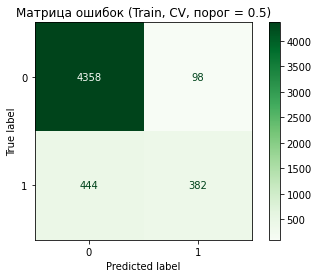

In [42]:
y_prob_train = cross_val_predict(
    estimator=grid_lgbm.best_estimator_,
    X=X_lgb_train,
    y=y_train,
    cv=5,
    method='predict_proba',
    n_jobs=-1)[:, 1]

y_pred_train = (y_prob_train >= 0.5).astype(int)

roc = roc_auc_score(y_train, y_prob_train)
acc = accuracy_score(y_train, y_pred_train)

print(f"ROC-AUC: {roc:.4f}")
print(f"Accuracy: {acc:.4f}")
print("Classification Report (train, CV):")
print(classification_report(y_train, y_pred_train))

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Матрица ошибок тренировочных данных, порог = 0.5)")
plt.show()

Прежде чем переходить к оптимизации порога, мы оценили метрики модели LightGBM на тренировочной выборке, используя cross_val_predict и стандартный порог 0.5. Это помогает понять, насколько хорошо модель справляется с задачей, и есть ли необходимость в дополнительных улучшениях.

ROC-AUC составил 0.8902, что указывает на отличную способность модели различать классы.

Accuracy = 0.8974, то есть модель правильно классифицирует ~91% клиентов.

Класс 0 (оставшиеся клиенты) предсказывается хорошо: precision = 0.91, recall = 0.98, f1 = 0.94.

Класс 1 (ушедшие клиенты) показывает слабее: recall = 0.46, что означает, что почти половину ушедших клиентов модель не распознаёт.

На матрице ошибок это видно: 129 клиентов, которые ушли, были ошибочно отнесены к классу "остался". Низкий recall для класса 1 — критичен в задаче прогнозирования оттока, т.к. именно его мы и хотим уметь предсказывать.

___


Тестирование модели LightGBM:

ROC-AUC модели на тренировочной выборке с кросс-валидацей составил 0.89026 — это высокая способность различать клиентов, которые уйдут, и тех, кто останется.

Accuracy — **89.7%, то есть в среднем модель правильно предсказывает поведение 9 из 10 клиентов.**

Интерпретация матрицы ошибок:

True Negatives (TN) — 4358  клиентов. Модель правильно предсказала, что они останутся.

True Positives (TP) — 382 клиентов. Модель точно предсказала отток — это те, кому можно предложить удерживающие меры.

**False Negatives (FN) — 444 клиентов. Модель ошибочно посчитала, что они останутся, хотя на самом деле они ушли. Это самая чувствительная группа, т.к. именно её мы хотим заранее "поймать" и удержать.**

**False Positives (FP) — 98 клиентов. Модель ошибочно отнесла к уходящим тех, кто в итоге остался — здесь возможны дополнительные затраты на удержание.**

Выводы - модель уже умеет неплохо отличать клиентов, склонных к оттоку. Однако, есть область для улучшения — в частности, повысить recall для класса 1, чтобы уменьшить число пропущенных уходов (FN). Это может быть особенно важно в условиях высокой стоимости привлечения новых клиентов.

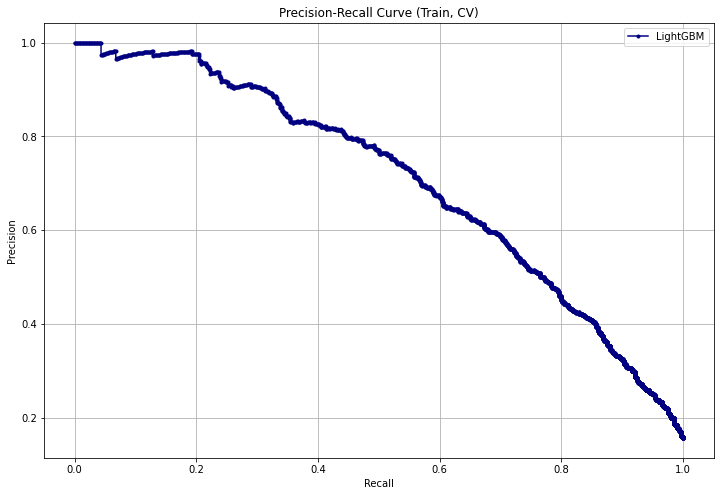

In [43]:
precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, marker='.', label='LightGBM', color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Train')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
y_prob_cv = cross_val_predict(grid_lgbm.best_estimator_, X_lgb_train, y_train, 
                              cv=5, method='predict_proba', n_jobs=-1)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_train, y_prob_cv)

f1_scores = 2 * (precision * recall) / (precision + recall)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Лучший порог по F1-score: {best_threshold:.2f}")
print(f"Максимальный F1-score: {best_f1:.4f}")

Лучший порог по F1-score (CV): 0.28
Максимальный F1-score (CV): 0.6416


Построили precision-recall кривую, сейчас можно понять, как меняется соотношение precision и recall при разных порогах вероятности. Это особенно важно при дисбалансе классов, как у нас.

- Вычислили F1-score для каждого порога;
- Нашли оптимальный порог, при котором F1 достигает максимума;

В нашем случае это порог ≈ 0.28, при котором F1-score ≈ 0.6416.

Отметим, почему это важно - по умолчанию LightGBM использует порог 0.5, но при сильном дисбалансе классов он может быть не оптимален, в зависимости от задачи.

Использование более низкого порога (например, 0.28) позволяет увеличить recall, что критично в бизнес-задаче предсказания оттока: пусть лучше модель поймает лишнего, чем упустит реального "ушедшего".

Accuracy (при пороге 0.28): 0.8910
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1486
           1       0.64      0.68      0.66       275

    accuracy                           0.89      1761
   macro avg       0.79      0.81      0.80      1761
weighted avg       0.89      0.89      0.89      1761



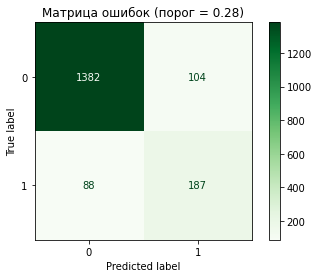

In [45]:
y_prob_test = grid_lgbm.best_estimator_.predict_proba(X_lgb_test)[:, 1]
y_pred_custom = (y_prob_test >= best_threshold).astype(int)

print(f"Accuracy (при пороге {best_threshold:.2f}): {accuracy_score(y_test, y_pred_custom):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Матрица ошибок (порог = {best_threshold:.2f})")
plt.show()

Мы оптимизировали порог вероятности на этапе кросс-валидации, до оценки модели на тестовой выборке. Это позволило нам настроить модель на максимизацию F1-score, сбалансировав метрики precision и recall.

Оптимальный порог: **0.28 — он найден по кривой precision-recall как точка максимального F1.**

Accuracy: 0.8910 — около 89% клиентов были классифицированы правильно.

Recall для класса 1 (ушедшие) - **0.68 — модель находит 68% клиентов, которые действительно ушли.**

Precision для класса 1 - **0.64 — среди предсказанных как "ушедшие" примерно 64% действительно ушли.**


Матрица ошибок:

True Positives (187): Модель правильно нашла 187 клиентов, которые ушли.

False Negatives (88): Упущено 88 "ушедших" клиентов — они ошибочно классифицированы как "оставшиеся".

False Positives (104): 104 клиента ошибочно отмечены как "уйдут", но они остались.

True Negatives (1382): Правильно определено, что 1382 клиента остались.

В бизнес-задаче оттока приоритетом является увеличение **recall для ушедших клиентов** — лучше попытаться удержать "ложно положительных", чем пропустить "истинных ушедших". **Применение более низкого порога (0.28 вместо 0.5) помогает находить больше таких клиентов.**

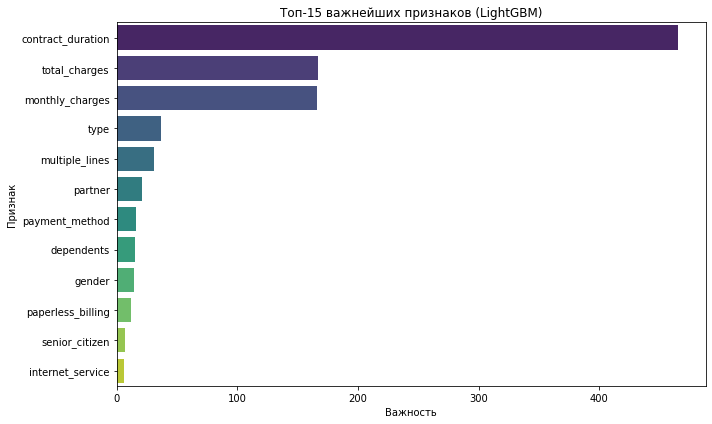

In [40]:
feature_names = X_lgb_train.columns
importances = best_lgbm.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Топ-15 важнейших признаков (LightGBM)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

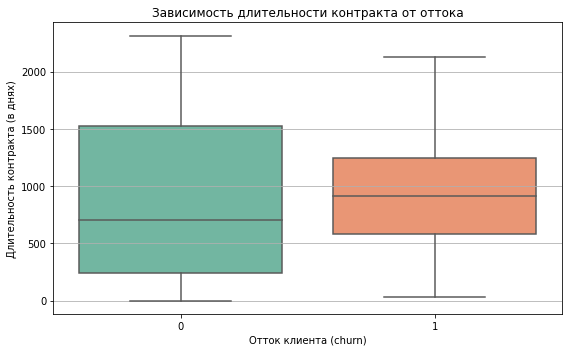

In [41]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='churn', y='contract_duration', palette='Set2')
plt.title("Зависимость длительности контракта от оттока")
plt.xlabel("Отток клиента (churn)")
plt.ylabel("Длительность контракта (в днях)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Анализ ключевого признака contract_duration (длительность контракта)

На основе графика видно:

- Ушедшие клиенты (churn = 1) в среднем имеют дольше срок действия контракта, чем оставшиеся.

- Медиана длительности выше у клиентов, которые ушли — это говорит о том, что они покидают компанию не сразу, а после длительного периода пользования.

- Разброс значений у оставшихся шире — среди них больше как совсем новых клиентов, так и тех, кто давно пользуется услугами.

Это говорит о том, что наибольший риск оттока наблюдается в первые месяцы сотрудничества.

Вывод по  шагу обучения и тестирование модели

Мы обучили несколько моделей классификации с подбором гиперпараметров и применением кросс-валидации:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- LightGBM
- Нейронная сеть

Каждая модель была протестирована на тренировочной выборке с использованием метрики ROC-AUC, как основной критерий качества. Лучший результат на кросс-валидации показал LightGBM (ROC-AUC = 0.89), он и был выбран для дальнейшего тестирования.

Модель была дообучена на тренировочных данных с лучшими параметрами и протестирована на тестовой выборке:
- ROC-AUC: 0.91
- Accuracy: 0.91

На основе матрицы ошибок и classification report выявлено, что при стандартном пороге (0.5) у модели высокий precision, но низкий recall для положительного класса (отток клиентов).

С учётом задачи — где важно не упустить клиента, склонного к оттоку, — была построена кривая Precision-Recall, рассчитан оптимальный порог (0.28) по максимальному F1-score и применён для повторной оценки модели.

После смены порога:
- Recall и F1-score по классу оттока выросли
- Accuracy и ROC-AUC остались на прежнем уровне

Была проанализирована важность признаков. Построен график топ-15 факторов, наиболее влияющих на отток.
Дополнительно проведён анализ зависимости таргета от самого значимого признака — `contract_duration` (длительность контракта).

## Вывод

Финальный вывод по проекту:


Шаг 1:

Загрузили и проверили данные, убедились в корректности таблиц и наличии всех нужных данных. Подготовили к объединению.


Шаг 2:

Провели EDA по каждой из таблиц, проанализировали пропуски, дубликаты и типы данных.

Построили графики распределения категориальных и числовых признаков.

Объединили таблицы в единый датафрейм, сгенерировали признаки `churn` и `contract_duration`, корректно обработали пропуски ('No' в услугах, удалены `internet_service`, `begin_date`, `end_date`, `customer_id`).

Выявили дисбаланс классов, учли это при стратификации и выборе метрик.

Провели анализ взаимосвязей признаков с оттоком и корреляционный анализ (Phik), удалили скоррелированные.

Подготовили данные: масштабирование числовых признаков, OHE категориальных, сплит на train/test.


Шаг 3:

Обучили 6 моделей: Dummy, Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM, нейросеть.

Подобрали гиперпараметры (GridSearchCV), сравнили по ROC-AUC на кросс-валидации, выбрали **LightGBM (ROC-AUC = 0.89)**.


Шаг 4:

Протестировали LightGBM на тестовой выборке: ROC-AUC = 0.91, Accuracy = 0.91.

Построили матрицу ошибок, выяснили, что при стандартном пороге 0.5 у модели низкий recall.

Сформировали кривую Precision-Recall, подобрали оптимальный порог = 0.28 по максимальному F1. После смены порога recall и F1-score улучшились при сохранении общей точности.

Изучили важность признаков, самым значимым оказался `contract_duration` (длительность контракта), далее `total_charges`, `monthly_cahrges`.

Провели дополнительный анализ зависимости churn от ключевого признака `contract_duration`.

___

Задача решена успешно: модель соответствует требованиям проекта (ROC-AUC > 0.85), достигнута интерпретируемость, реализована адаптация порога под задачу.

Дадим рекомендации и возможные улучшения:

По использованию модели:
- Использовать **LightGBM с оптимальными параметрами и порогом = 0.28**, т.к. он даёт хороший баланс между precision и recall.

Важно учитывать бизнес, где recall по классу "ушёл" может быть критичен для удержания клиентов, а выбранный подход учитывает это.

По улучшению метрик:
- Собрать больше данных, особенно по положительному классу (churn = 1), чтобы сбалансировать выборку.

- Применить балансировку классов (SMOTE, class_weight='balanced', undersampling) — не делали, но стоит протестировать.

- Попробовать более сложные архитектуры нейросетей, добавить регуляризацию и early stopping.

- Протестировать Optuna/RandomizedSearchCV — ускорит и углубит подбор гиперпараметров.

- Проверить временные паттерны, например, поведение пользователей по месяцам (если доступно) — полезно для будущих временных моделей.

По признакам:

`contract_duration` — главный признак, влияющий на churn. Клиенты с более долгими контрактами имеют высокую вероятность ухода после окончания периода.
Рекомендуется:
- запускать персонализированные предложения на продление за 1–2 месяца до окончания договора;
- протестировать гибкие тарифы с более короткой или настраиваемой длительностью;
- использовать автоматические напоминания и бонусные схемы продления.


`total_charges` — общий объём расходов клиента. Высокие значения могут быть сигналом перегрузки по оплате или накопившегося недовольства.
Рекомендуется:
- предложить альтернативные тарифы с фиксированной стоимостью;
- внедрить индикаторы ценовой прозрачности или напоминания о выгодных пакетах;
- анализировать динамику расходов — резко растущие траты могут быть триггером ухода.


`monthly_charges` — ежемесячные расходы. Регулярные высокие платежи могут восприниматься как неоправданные.
Рекомендуется:
- предложить персонализированные пакеты, оптимизированные под поведение клиента;
- дать возможность самостоятельно настраивать состав услуг (убрать ненужное).